## Data Preparation, re-run when changing TARGET(SBP, DBP, MAP)

In [22]:
TARGET = 'MAP' # SBP or DBP or MAP
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
take_log_PTT = 0 # if not log, then all values are positive & the outliers are as defined
Remove_HR_Outliers = 1 # =1 if required more constraints on HR ( 54.4 < HR < 155.8) 
Remove_PTT_Outliers = 1
Remove_BP_Outliers = 1

Remove_PTTm_Outliers = 0 #(PATf)
Remove_PTTh_Outliers = 0 #(PPG Max-to-Min)


All_Instants_Data2 = pd.read_csv('Extracted_Instants_Parameters_8secWindow_PTTm_PTTh_MAP_210621.csv')
All_Instants_Data2.dropna(inplace=True)
All_Instants_Data = All_Instants_Data2

if take_log_PTT != 1:
    All_Instants_Data['PTT'] = np.exp(All_Instants_Data['PTT']) ################ NOT LOG ANYMORE # By commenting this, it is log
    All_Instants_Data['PTTm'] = np.exp(All_Instants_Data['PTTm'])

# Removing BP Outliers
if Remove_BP_Outliers == 1:
    cond_BP = ((All_Instants_Data['SBP']<180) & (All_Instants_Data['SBP']>80)) & ((All_Instants_Data['DBP']<130) & (All_Instants_Data['DBP']>60))
    All_Instants_Data= All_Instants_Data.loc[cond_BP, ['PTTh','PTTm','PTT','HR','SBP', 'DBP','MAP']]

# Removing HR Outliers
if Remove_HR_Outliers == 1: 
    cond_HR = ((All_Instants_Data['HR']>54.4) & (All_Instants_Data['HR']<155.8))
    All_Instants_Data= All_Instants_Data.loc[cond_HR, ['PTTh','PTTm','PTT','HR','SBP', 'DBP','MAP']]
    
# Removing PTT Ouliers (outlier if PTT>1.5) # So far, considering PTT<0.5 range gave the best result
if Remove_PTT_Outliers == 1: 
    cond_PTT = (All_Instants_Data['PTT']<0.4) #& (All_Instants_Data['PTT']>0.2)#& (All_Instants_Data['PTT']>.015) #### KEEP <0.4 only ##################
    All_Instants_Data= All_Instants_Data.loc[cond_PTT, ['PTTh','PTTm','PTT','HR','SBP', 'DBP','MAP']]
    
# Removing PTTm (PATf) Outliers
if Remove_PTTm_Outliers == 1: 
    cond_PTTm = ((All_Instants_Data['PTTm']>0.7) & (All_Instants_Data['PTTm']<1.5))
    All_Instants_Data= All_Instants_Data.loc[cond_PTTm, ['PTTh','PTTm','PTT','HR','SBP', 'DBP','MAP']]
    
# Removing PTTh (PPG Max-to-Min) Outliers
if Remove_PTTh_Outliers == 1: 
    cond_PTTh = ((All_Instants_Data['PTTh']>1) & (All_Instants_Data['PTTh']<2))
    All_Instants_Data= All_Instants_Data.loc[cond_PTTh, ['PTTh','PTTm','PTT','HR','SBP', 'DBP','MAP']]

    



temp_data = All_Instants_Data.loc[:, ['PTTh','PTTm','PTT','HR']]
train_copy2_tr, testData, train_labels, test_labels = train_test_split(temp_data, All_Instants_Data[TARGET], test_size=0.2, random_state=42,shuffle=True)



## PC-to-MCU Connection + Helper Functions, run when the MCU is loaded and plugged

In [29]:
# Connection Information: 
connectPort = 'COM7' ######################## PORT: COM6 for Arduino, COM9 for ESP, COM7 for PyBadge 
Baud_Rate = 115200
startMarker = 60
endMarker = 62

import pandas as pd
#=====================================

#  Function Definitions

#=====================================


def sendToArduino(sendStr):
  ser.write(bytes(sendStr, 'utf-8'))


#======================================

def recvFromArduino():
  global startMarker, endMarker
  
  ck = ""
  x = "z" # any value that is not an end- or startMarker
  byteCount = -1 # to allow for the fact that the last increment will be one too many
  
  # wait for the start character
  while  ord(x) != startMarker: 
    x = ser.read()
  
  # save data until the end marker is found
  while ord(x) != endMarker:
    if ord(x) != startMarker:
      ck = ck + x.decode('utf-8')
      byteCount += 1
    x = ser.read()
  
  
  return(ck) 


#============================

def waitForArduino():

   # wait until the Arduino sends 'Arduino Ready' - allows time for Arduino reset
   # it also ensures that any bytes left over from a previous message are discarded
   
    global startMarker, endMarker
    
    msg = ""
    while msg.find("Arduino is ready") == -1:

      while ser.inWaiting() == 0:
        pass
        
      msg = recvFromArduino()

      print (msg)
      print ("\n")
      


#======================================


def runTest(td):
  import pandas as pd
  MCU_pred=pd.DataFrame()
    
  numLoops = len(td)
  waitingForReply = False

  n = 0
  while n < numLoops:

    teststr = td[n]

    if waitingForReply == False:
        sendToArduino(teststr)
        #print ("Sent from PC -- LOOP NUM " + str(n) + " TEST STR " + teststr)
        waitingForReply = True

    if waitingForReply == True:

        while ser.inWaiting() == 0:
            pass
      
        str_from_MCU = recvFromArduino()
        chunks = str_from_MCU.split(',')
        P_SBP = float(chunks[0])
        #P_DBP = float(chunks[1])
        infTime = int(chunks[1])  ##########################################
        
        #Subset_DF = pd.DataFrame({'Pred_SBP':[P_SBP],'Pred_DBP':[P_DBP],'Inf_Time':[infTime]})
        Subset_DF = pd.DataFrame({'Pred_SBP':[P_SBP],'Inf_Time':[infTime]})
        MCU_pred = MCU_pred.append(Subset_DF, ignore_index=True)
      
        n += 1
        waitingForReply = False
    
    #print ("===========")
  return MCU_pred
    #time.sleep(5) ####################################### should I keep this? let's see!


#======================================

# THE DEMO PROGRAM STARTS HERE

#======================================

import serial
import time


print
print




# Establish Connection 

if connectPort != 'None':
    ser = serial.Serial(connectPort,baudrate = Baud_Rate, timeout=1)
    print('Connected to ' + connectPort)
else:
    print('Connection Issue!')

#waitForArduino()


Num_Test_Points = 5 # you may use it with the testData assignment for faster test. 
Total_length = len(testData.index)
round_dig = 5
 
PackedDataList = [] # THAT IS A LIST APPARENTLY!
for i in range(len(testData.index)):
    new_str = '<' + str(testData['PTTh'].iloc[i].round(round_dig)) + ',' + str(testData['PTTm'].iloc[i].round(round_dig)) + ',' + str(testData['PTT'].iloc[i].round(round_dig)) + ',' + str(testData['HR'].iloc[i].round(round_dig)) + '>'
    PackedDataList.append(new_str) 

Predictions_df = runTest(PackedDataList) 
ser.close

Connected to COM7


<bound method Serial.close of Serial<id=0x22ef179cd30, open=True>(port='COM7', baudrate=115200, bytesize=8, parity='N', stopbits=1, timeout=1, xonxoff=False, rtscts=False, dsrdtr=False)>

In [4]:
Predictions_df[Predictions_df['Pred_SBP'].isna()]

,Pred_SBP,Inf_Time


## Error Calculations, ME, MAE, Std, CDF, Time, and Saving Results

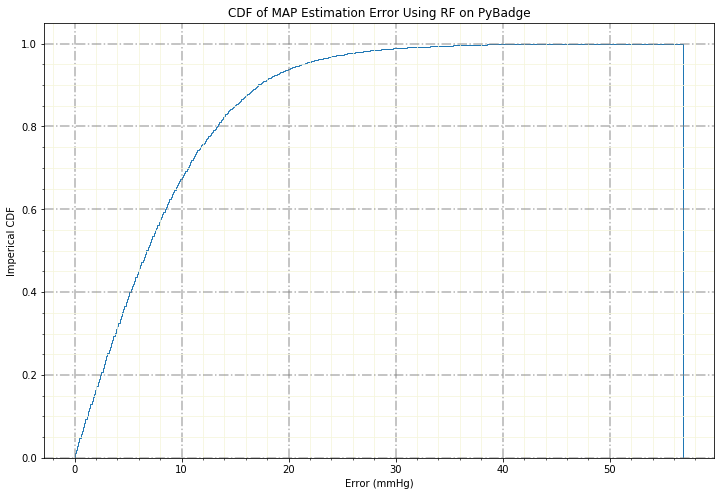

In [30]:
import joblib 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


MCU = 'PyBadge'
Alg = 'RF'

Results_file = 'MCU_Results/'+ MCU + TARGET+'_Results_' +'.txt'
CDF_file = 'MCU_Results/'+ TARGET + '_' + MCU + '_Error_CDF_' + Alg +'.svg'
Test_Error_file = 'MCU_Results/'+ TARGET + '_' + MCU + '_Test_Error_' + Alg +'.pkl'


Test_Error = test_labels.values - Predictions_df['Pred_SBP'].values
Test_ME = np.mean(Test_Error)
Inf_Times_avg = np.mean(Predictions_df['Inf_Time'].values)
Test_std = np.std(Test_Error)
Test_MAE = np.mean(abs(Test_Error))
joblib.dump(Test_Error, Test_Error_file)

# Writing Results in Text File: 
textfile = open(Results_file, 'a')
textfile.write('Results for ' + TARGET + ' ' + Alg + ' '+ MCU + '\n')
textfile.write('Test ME: ' + str(Test_ME) + '\n')
textfile.write('Test Std: ' + str(Test_std) + '\n')
textfile.write('Test MAE: ' + str(Test_MAE) + '\n')
textfile.write('Average Inference Time: ' + str(Inf_Times_avg) + '\n')
textfile.write('=========================================' + '\n')
textfile.close()

# Plot & Save CDF of Error
fig, ax = plt.subplots(figsize=(12, 8));
ax.hist(abs(Test_Error), 500, density=1, histtype='step', cumulative=True, label='Empirical');
plt.grid(b=True, which='major', color='gray', alpha=0.6, linestyle='dashdot', lw=1.5)
#minor grid lines
plt.minorticks_on()
plt.xlabel('Error (mmHg)')
plt.ylabel('Imperical CDF')
plt.title('CDF of %s Estimation Error Using %s on %s' %(TARGET, Alg, MCU))
plt.grid(b=True, which='minor', color='beige', alpha=0.8, ls='-', lw=1)
plt.savefig(CDF_file, format='svg', dpi=1200)

In [65]:
print('Results for ' + 'SBP-LR-MCU' + '\n')
print('Test ME: ' + str(Test_ME) + '\n')
print('Test Std: ' + str(Test_std) + '\n')
print('Test MAE: ' + str(Test_MAE) + '\n')
print('Average Inference Time: ' + str(Inf_Times_avg) + '\n')
print('=========================================' + '\n')

Results for SBP-LR-MCU

Test ME: 0.07325786023380236

Test Std: 20.35652029661403

Test MAE: 16.702810081440706

Average Inference Time: 71.1622877738784




In [42]:
import joblib
joblib.dump(Predictions_df,"Predictions_df_LR_Ard_0414.pkl")

['Predictions_df_LR_Ard_0414.pkl']